In [1]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm_notebook as tqdm

C:\Users\Sundeep\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print(os.listdir('C:\\Users\\Sundeep\\Desktop\\keras-oneshot-master\\chest_xray'))

['test', 'train', 'val']


In [3]:
TRAIN_DIR = "C:\\Users\\Sundeep\\Desktop\\keras-oneshot-master\\chest_xray\\train\\"
TEST_DIR =  "C:\\Users\\Sundeep\\Desktop\\keras-oneshot-master\\chest_xray\\test\\"

In [4]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [5]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [6]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [7]:
X_train, y_train = get_data(TRAIN_DIR)

C:\Users\Sundeep\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [8]:
X_test , y_test = get_data(TEST_DIR)

C:\Users\Sundeep\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [9]:
print(X_train.shape,'\n',X_test.shape)

(5216, 150, 150, 3) 
 (624, 150, 150, 3)


In [10]:
# from keras.utils.np_utils import to_categorical

# y_train = to_categorical(y_train, 2)
# y_test = to_categorical(y_test, 2)

In [11]:
print(y_train.shape,'\n',y_test.shape)

(5216,) 
 (624,)


In [12]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [13]:
# import pickle
# with open('X_train.pkl','wb') as f:
#     pickle.dump(X_train, f)

In [14]:

Pimages = os.listdir(TRAIN_DIR + "PNEUMONIA")
Nimages = os.listdir(TRAIN_DIR + "NORMAL")

In [15]:
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [16]:

X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)

In [17]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

In [18]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten(name = 'Features_CNN'))

model.add(Dense(64, activation='relu', name = 'Features_MLP'))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))


In [19]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=7)

Epoch 1/7
5216/5216 [==============================] - ETA: 12:07 - loss: 0.6919 - acc: 0.62 - ETA: 11:13 - loss: 0.6746 - acc: 0.70 - ETA: 10:51 - loss: 0.6385 - acc: 0.72 - ETA: 10:40 - loss: 0.7686 - acc: 0.71 - ETA: 10:33 - loss: 0.7499 - acc: 0.71 - ETA: 10:26 - loss: 0.7387 - acc: 0.69 - ETA: 10:15 - loss: 0.7260 - acc: 0.70 - ETA: 10:02 - loss: 0.7188 - acc: 0.72 - ETA: 9:51 - loss: 0.7136 - acc: 0.7326 - ETA: 9:41 - loss: 0.7099 - acc: 0.740 - ETA: 9:33 - loss: 0.7077 - acc: 0.730 - ETA: 9:24 - loss: 0.7049 - acc: 0.729 - ETA: 9:15 - loss: 0.7026 - acc: 0.733 - ETA: 9:09 - loss: 0.7010 - acc: 0.727 - ETA: 9:03 - loss: 0.6982 - acc: 0.727 - ETA: 8:56 - loss: 0.6960 - acc: 0.722 - ETA: 8:49 - loss: 0.6932 - acc: 0.720 - ETA: 8:43 - loss: 0.6902 - acc: 0.720 - ETA: 8:37 - loss: 0.6820 - acc: 0.727 - ETA: 8:31 - loss: 0.6878 - acc: 0.720 - ETA: 8:26 - loss: 0.6783 - acc: 0.724 - ETA: 8:21 - loss: 0.6750 - acc: 0.724 - ETA: 8:16 - loss: 0.6739 - acc: 0.724 - ETA: 8:10 - loss: 0.6699

5216/5216 [==============================] - ETA: 8:51 - loss: 0.1674 - acc: 1.000 - ETA: 8:50 - loss: 0.1767 - acc: 0.984 - ETA: 8:47 - loss: 0.2381 - acc: 0.937 - ETA: 8:44 - loss: 0.2669 - acc: 0.929 - ETA: 8:40 - loss: 0.2646 - acc: 0.912 - ETA: 8:38 - loss: 0.2637 - acc: 0.901 - ETA: 8:34 - loss: 0.2589 - acc: 0.897 - ETA: 8:30 - loss: 0.2821 - acc: 0.890 - ETA: 8:27 - loss: 0.2720 - acc: 0.892 - ETA: 8:23 - loss: 0.2587 - acc: 0.900 - ETA: 8:20 - loss: 0.2515 - acc: 0.900 - ETA: 8:17 - loss: 0.2451 - acc: 0.901 - ETA: 8:15 - loss: 0.2377 - acc: 0.903 - ETA: 8:12 - loss: 0.2386 - acc: 0.901 - ETA: 8:09 - loss: 0.2427 - acc: 0.897 - ETA: 8:05 - loss: 0.2475 - acc: 0.898 - ETA: 8:02 - loss: 0.2453 - acc: 0.898 - ETA: 8:00 - loss: 0.2445 - acc: 0.897 - ETA: 7:57 - loss: 0.2412 - acc: 0.898 - ETA: 7:53 - loss: 0.2532 - acc: 0.896 - ETA: 7:50 - loss: 0.2517 - acc: 0.897 - ETA: 7:47 - loss: 0.2457 - acc: 0.902 - ETA: 7:43 - loss: 0.2408 - acc: 0.903 - ETA: 7:40 - loss: 0.2402 - acc: 0.9

5216/5216 [==============================] - ETA: 9:02 - loss: 0.1597 - acc: 0.937 - ETA: 8:52 - loss: 0.1702 - acc: 0.937 - ETA: 8:48 - loss: 0.1563 - acc: 0.937 - ETA: 8:45 - loss: 0.1997 - acc: 0.914 - ETA: 8:42 - loss: 0.1776 - acc: 0.925 - ETA: 8:38 - loss: 0.1954 - acc: 0.911 - ETA: 8:35 - loss: 0.1895 - acc: 0.910 - ETA: 8:31 - loss: 0.1862 - acc: 0.910 - ETA: 8:28 - loss: 0.1736 - acc: 0.916 - ETA: 8:24 - loss: 0.1630 - acc: 0.925 - ETA: 8:21 - loss: 0.1582 - acc: 0.929 - ETA: 8:18 - loss: 0.1478 - acc: 0.934 - ETA: 8:15 - loss: 0.1391 - acc: 0.939 - ETA: 8:12 - loss: 0.1441 - acc: 0.942 - ETA: 8:09 - loss: 0.1566 - acc: 0.937 - ETA: 8:06 - loss: 0.1562 - acc: 0.935 - ETA: 8:03 - loss: 0.1545 - acc: 0.937 - ETA: 7:59 - loss: 0.1487 - acc: 0.941 - ETA: 7:56 - loss: 0.1493 - acc: 0.940 - ETA: 7:52 - loss: 0.1513 - acc: 0.940 - ETA: 7:49 - loss: 0.1722 - acc: 0.937 - ETA: 7:46 - loss: 0.1704 - acc: 0.937 - ETA: 7:43 - loss: 0.1674 - acc: 0.937 - ETA: 7:39 - loss: 0.1711 - acc: 0.9

5216/5216 [==============================] - ETA: 11:56 - loss: 0.0901 - acc: 1.00 - ETA: 11:17 - loss: 0.1584 - acc: 0.93 - ETA: 10:26 - loss: 0.1553 - acc: 0.93 - ETA: 9:59 - loss: 0.1698 - acc: 0.9297 - ETA: 9:41 - loss: 0.1704 - acc: 0.937 - ETA: 9:28 - loss: 0.1605 - acc: 0.937 - ETA: 9:25 - loss: 0.1812 - acc: 0.937 - ETA: 9:29 - loss: 0.1755 - acc: 0.941 - ETA: 9:42 - loss: 0.1662 - acc: 0.944 - ETA: 9:37 - loss: 0.1586 - acc: 0.950 - ETA: 9:29 - loss: 0.1499 - acc: 0.954 - ETA: 9:21 - loss: 0.1462 - acc: 0.953 - ETA: 9:13 - loss: 0.1377 - acc: 0.956 - ETA: 9:06 - loss: 0.1434 - acc: 0.953 - ETA: 8:59 - loss: 0.1365 - acc: 0.956 - ETA: 8:53 - loss: 0.1458 - acc: 0.949 - ETA: 8:47 - loss: 0.1415 - acc: 0.950 - ETA: 8:41 - loss: 0.1395 - acc: 0.949 - ETA: 8:36 - loss: 0.1564 - acc: 0.947 - ETA: 8:31 - loss: 0.1565 - acc: 0.948 - ETA: 8:26 - loss: 0.1579 - acc: 0.947 - ETA: 8:21 - loss: 0.1546 - acc: 0.948 - ETA: 8:16 - loss: 0.1565 - acc: 0.948 - ETA: 8:11 - loss: 0.1556 - acc: 0.

In [20]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
# y_true = np.argmax(y_test,axis = 1)


In [21]:
y_true = y_test

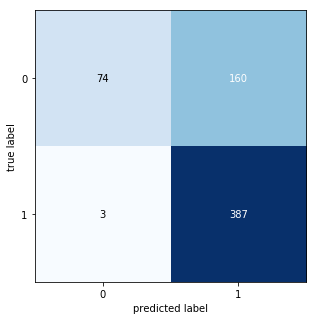

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [26]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, pred)

(array([0.96103896, 0.70749543]),
 array([0.31623932, 0.99230769]),
 array([0.47588424, 0.82604055]),
 array([234, 390], dtype=int64))

In [27]:
(382+86)/ (382+8+86+148)

0.75

In [106]:
model1 = Sequential()
model1.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model1.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model1.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model1.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
# model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model1.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
# model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(196, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model1.add(Conv2D(196, (3, 3), padding="valid", activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(252, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model1.add(Conv2D(252, (3, 3), padding="valid", activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten(name = 'Features_CNN'))

model1.add(Dense(64, activation='relu', name = 'Features_MLP'))
model1.add(Dropout(0.4))
model1.add(Dense(2 , activation='sigmoid'))


In [107]:
model1.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model1.fit(X_train, y_train, epochs=5)

Epoch 1/5
5216/5216 [==============================] - ETA: 13:14 - loss: 0.6936 - acc: 0.34 - ETA: 14:52 - loss: 0.6908 - acc: 0.46 - ETA: 13:38 - loss: 0.6656 - acc: 0.53 - ETA: 13:11 - loss: 0.6398 - acc: 0.60 - ETA: 13:07 - loss: 0.7968 - acc: 0.58 - ETA: 12:40 - loss: 0.8775 - acc: 0.54 - ETA: 12:18 - loss: 0.8384 - acc: 0.52 - ETA: 12:01 - loss: 0.9164 - acc: 0.50 - ETA: 11:47 - loss: 0.9100 - acc: 0.52 - ETA: 11:34 - loss: 1.1141 - acc: 0.52 - ETA: 11:23 - loss: 1.1596 - acc: 0.49 - ETA: 11:14 - loss: 1.1189 - acc: 0.47 - ETA: 11:05 - loss: 1.1216 - acc: 0.45 - ETA: 10:58 - loss: 1.1536 - acc: 0.43 - ETA: 10:50 - loss: 1.1186 - acc: 0.43 - ETA: 10:43 - loss: 1.1496 - acc: 0.42 - ETA: 10:36 - loss: 1.1227 - acc: 0.41 - ETA: 10:30 - loss: 1.1232 - acc: 0.41 - ETA: 10:24 - loss: 1.1259 - acc: 0.39 - ETA: 10:18 - loss: 1.1032 - acc: 0.38 - ETA: 10:12 - loss: 1.0837 - acc: 0.38 - ETA: 10:08 - loss: 1.0879 - acc: 0.37 - ETA: 10:03 - loss: 1.0898 - acc: 0.36 - ETA: 9:57 - loss: 1.0714 

5216/5216 [==============================] - ETA: 12:41 - loss: 1.1102 - acc: 0.21 - ETA: 12:25 - loss: 1.1427 - acc: 0.29 - ETA: 12:09 - loss: 1.4604 - acc: 0.30 - ETA: 11:52 - loss: 1.5042 - acc: 0.28 - ETA: 11:47 - loss: 1.4384 - acc: 0.27 - ETA: 11:36 - loss: 1.3106 - acc: 0.29 - ETA: 11:23 - loss: 1.2912 - acc: 0.28 - ETA: 11:12 - loss: 1.2767 - acc: 0.28 - ETA: 11:02 - loss: 1.2119 - acc: 0.27 - ETA: 10:54 - loss: 1.2521 - acc: 0.27 - ETA: 10:47 - loss: 1.1973 - acc: 0.27 - ETA: 10:40 - loss: 1.1553 - acc: 0.27 - ETA: 10:33 - loss: 1.1552 - acc: 0.26 - ETA: 10:27 - loss: 1.1206 - acc: 0.26 - ETA: 10:21 - loss: 1.1214 - acc: 0.26 - ETA: 10:15 - loss: 1.1220 - acc: 0.26 - ETA: 10:10 - loss: 1.1535 - acc: 0.26 - ETA: 10:05 - loss: 1.1803 - acc: 0.26 - ETA: 9:59 - loss: 1.1547 - acc: 0.2615 - ETA: 9:54 - loss: 1.2028 - acc: 0.260 - ETA: 9:49 - loss: 1.2244 - acc: 0.261 - ETA: 9:44 - loss: 1.2222 - acc: 0.257 - ETA: 9:40 - loss: 1.1983 - acc: 0.256 - ETA: 9:35 - loss: 1.1772 - acc: 0.

5216/5216 [==============================] - ETA: 12:15 - loss: 1.1752 - acc: 0.15 - ETA: 12:11 - loss: 1.1535 - acc: 0.31 - ETA: 12:21 - loss: 1.0001 - acc: 0.28 - ETA: 12:02 - loss: 0.9233 - acc: 0.28 - ETA: 11:40 - loss: 0.8686 - acc: 0.28 - ETA: 11:23 - loss: 0.8394 - acc: 0.29 - ETA: 11:10 - loss: 0.8843 - acc: 0.29 - ETA: 11:00 - loss: 0.9809 - acc: 0.29 - ETA: 10:50 - loss: 0.9977 - acc: 0.29 - ETA: 10:46 - loss: 1.0636 - acc: 0.31 - ETA: 10:40 - loss: 1.0718 - acc: 0.30 - ETA: 10:34 - loss: 1.0786 - acc: 0.30 - ETA: 10:29 - loss: 1.0860 - acc: 0.30 - ETA: 10:22 - loss: 1.0580 - acc: 0.30 - ETA: 10:16 - loss: 1.0658 - acc: 0.30 - ETA: 10:09 - loss: 1.0411 - acc: 0.29 - ETA: 10:04 - loss: 1.0774 - acc: 0.29 - ETA: 9:58 - loss: 1.1084 - acc: 0.2917 - ETA: 9:53 - loss: 1.0865 - acc: 0.282 - ETA: 9:48 - loss: 1.0910 - acc: 0.285 - ETA: 9:42 - loss: 1.0710 - acc: 0.282 - ETA: 9:37 - loss: 1.0738 - acc: 0.281 - ETA: 9:34 - loss: 1.0763 - acc: 0.278 - ETA: 9:29 - loss: 1.0603 - acc: 0.

In [164]:
model2 = Sequential()
model2.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model2.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model2.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model2.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
# model1.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model2.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
# model1.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model2.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
# model1.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model2.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
# model1.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model2.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
# model1.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(196, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model2.add(Conv2D(196, (3, 3), padding="valid", activation='relu'))
# model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Flatten(name = 'Features_CNN'))
# model2.add(Dense(256, activation='relu'))
# model2.add(Dropout(0.4))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu', name = 'Features_MLP'))
model2.add(Dense(2, activation='sigmoid'))


In [165]:
model2.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(X_train, y_train, epochs=5)

Epoch 1/5
5216/5216 [==============================] - ETA: 30:50 - loss: 0.6931 - acc: 0.65 - ETA: 25:12 - loss: 0.6885 - acc: 0.71 - ETA: 23:12 - loss: 0.6648 - acc: 0.75 - ETA: 22:07 - loss: 0.6693 - acc: 0.71 - ETA: 21:31 - loss: 0.6722 - acc: 0.72 - ETA: 21:02 - loss: 0.6737 - acc: 0.73 - ETA: 20:42 - loss: 0.6755 - acc: 0.72 - ETA: 20:23 - loss: 0.6755 - acc: 0.72 - ETA: 20:03 - loss: 0.6737 - acc: 0.73 - ETA: 19:43 - loss: 0.6693 - acc: 0.74 - ETA: 19:26 - loss: 0.6628 - acc: 0.75 - ETA: 19:11 - loss: 0.6603 - acc: 0.74 - ETA: 18:58 - loss: 0.6435 - acc: 0.75 - ETA: 18:44 - loss: 0.6224 - acc: 0.76 - ETA: 18:35 - loss: 0.6296 - acc: 0.76 - ETA: 18:25 - loss: 0.6260 - acc: 0.76 - ETA: 18:15 - loss: 0.6243 - acc: 0.75 - ETA: 18:03 - loss: 0.6255 - acc: 0.75 - ETA: 17:53 - loss: 0.6250 - acc: 0.75 - ETA: 17:42 - loss: 0.6215 - acc: 0.75 - ETA: 17:33 - loss: 0.6180 - acc: 0.76 - ETA: 17:22 - loss: 0.6192 - acc: 0.75 - ETA: 17:12 - loss: 0.6193 - acc: 0.75 - ETA: 17:03 - loss: 0.6204

5216/5216 [==============================] - ETA: 14:58 - loss: 0.6300 - acc: 0.68 - ETA: 14:59 - loss: 0.5403 - acc: 0.78 - ETA: 14:52 - loss: 0.5075 - acc: 0.81 - ETA: 14:43 - loss: 0.4986 - acc: 0.82 - ETA: 14:37 - loss: 0.5189 - acc: 0.80 - ETA: 14:34 - loss: 0.5566 - acc: 0.76 - ETA: 14:27 - loss: 0.5479 - acc: 0.77 - ETA: 14:23 - loss: 0.5419 - acc: 0.77 - ETA: 14:21 - loss: 0.5524 - acc: 0.76 - ETA: 14:15 - loss: 0.5672 - acc: 0.75 - ETA: 14:09 - loss: 0.5572 - acc: 0.76 - ETA: 14:03 - loss: 0.5567 - acc: 0.76 - ETA: 13:55 - loss: 0.5517 - acc: 0.76 - ETA: 13:49 - loss: 0.5546 - acc: 0.76 - ETA: 13:43 - loss: 0.5697 - acc: 0.74 - ETA: 13:37 - loss: 0.5648 - acc: 0.75 - ETA: 13:31 - loss: 0.5590 - acc: 0.75 - ETA: 13:25 - loss: 0.5612 - acc: 0.75 - ETA: 13:18 - loss: 0.5614 - acc: 0.75 - ETA: 13:13 - loss: 0.5686 - acc: 0.74 - ETA: 13:07 - loss: 0.5715 - acc: 0.74 - ETA: 13:02 - loss: 0.5741 - acc: 0.74 - ETA: 12:57 - loss: 0.5761 - acc: 0.74 - ETA: 12:51 - loss: 0.5769 - acc: 0.

5216/5216 [==============================] - ETA: 11:04 - loss: 0.5314 - acc: 0.78 - ETA: 11:03 - loss: 0.5661 - acc: 0.75 - ETA: 10:57 - loss: 0.5940 - acc: 0.72 - ETA: 10:53 - loss: 0.5781 - acc: 0.74 - ETA: 10:49 - loss: 0.5676 - acc: 0.75 - ETA: 10:44 - loss: 0.5790 - acc: 0.73 - ETA: 10:41 - loss: 0.5829 - acc: 0.73 - ETA: 10:37 - loss: 0.5762 - acc: 0.74 - ETA: 10:33 - loss: 0.5741 - acc: 0.74 - ETA: 10:28 - loss: 0.5772 - acc: 0.74 - ETA: 10:24 - loss: 0.5731 - acc: 0.74 - ETA: 10:20 - loss: 0.5742 - acc: 0.74 - ETA: 10:16 - loss: 0.5654 - acc: 0.75 - ETA: 10:12 - loss: 0.5653 - acc: 0.75 - ETA: 10:08 - loss: 0.5651 - acc: 0.75 - ETA: 10:04 - loss: 0.5646 - acc: 0.75 - ETA: 10:00 - loss: 0.5706 - acc: 0.74 - ETA: 9:56 - loss: 0.5681 - acc: 0.7465 - ETA: 9:52 - loss: 0.5641 - acc: 0.750 - ETA: 9:48 - loss: 0.5637 - acc: 0.750 - ETA: 9:44 - loss: 0.5633 - acc: 0.750 - ETA: 9:39 - loss: 0.5646 - acc: 0.748 - ETA: 9:35 - loss: 0.5630 - acc: 0.750 - ETA: 9:31 - loss: 0.5648 - acc: 0.

In [166]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

624/624 [==============================] - ETA: 34 - ETA: 32 - ETA: 30 - ETA: 29 - ETA: 27 - ETA: 25 - ETA: 23 - ETA: 21 - ETA: 19 - ETA: 17 - ETA: 15 - ETA: 14 - ETA: 12 - ETA: 10 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - 36s 58ms/step
Test accuracy: 0.7387820512820513


In [29]:
from keras.models import Model
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('Features_CNN').output)
training_data = intermediate_layer_model.predict(X_train)

In [30]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('Features_CNN').output)
intermediate_output = intermediate_layer_model.predict(X_test)

In [47]:
import os
os.chdir(r'C:\Users\Sundeep\Desktop\keras-oneshot-master')

In [32]:
def datatoBET(X_train, y_train, model):
    
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('Features_CNN').output)
    training_data = intermediate_layer_model.predict(X_train)
    
    y1 = pd.DataFrame(y_train)
    y2 = pd.get_dummies(y1[0])
    y2.columns = [str('Target_') +str(x) for x in range(0,2)]
    df = pd.DataFrame(training_data)
    train_data = pd.concat([df, y2], axis=1)
    
    return bet.create_bet(train_data)
    
    

In [51]:
def model_pred(BET_):
    
    from artml.explore import stats
    df_stats = stats.univariate(BET_)
    a = np.array(df_stats.loc[['Standard_deviation']])
    b = np.argwhere(a == 0)
    BET = BET_.drop(list(b[:,1]), 1)
    BET = BET.drop(list(b[:,1]))
    
    import artml
    from artml.models import QDA
    qda = QDA.QuadraticDiscriminantAnalysis()
    qda.fit(BET, 'Target_0', 'Target_1')
    y_pred_QDA = qda.predict(pd.DataFrame(intermediate_output).drop(list(b[:,1]), 1))
    y_prob_QDA = qda.ensemble_predict(pd.DataFrame(intermediate_output).drop(list(b[:,1]), 1))
    qda_score = qda.score(pd.DataFrame(intermediate_output).drop(list(b[:,1]), 1), np.array(y_test.flatten()))
    print("accuracy for QDA classifier is: " + str(qda_score))
    
    from artml.models import naive_bayes
    gnb = naive_bayes.GaussianNB()
    gnb.fit(BET, 'Target_0', 'Target_1')
    y_pred_gnb = gnb.predict(pd.DataFrame(intermediate_output).drop(list(b[:,1]), 1).values)
    y_prob_gnb = gnb.predict_log_proba(pd.DataFrame(intermediate_output).drop(list(b[:,1]), 1).values)
    gnb_score = gnb.score(pd.DataFrame(intermediate_output).drop(list(b[:,1]), 1).as_matrix(), np.array(y_test.flatten()))
    print("accuracy for Naive bayes classifier is: " + str(gnb_score))
    
    return y_pred_QDA, y_prob_QDA, y_pred_gnb, y_prob_gnb

In [49]:
from artml import bet

In [50]:
BET_dataset1 = datatoBET(X_train, y_train, model)

In [52]:
y_pred_QDA_main1, y_prob_QDA_main1, y_pred_gnb_main1, y_prob_gnb_main1 = model_pred(BET_dataset1)

Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
accuracy for QDA classifier is: 0.7564102564102564
accuracy for Naive bayes classifier is: 0.7788461538461539


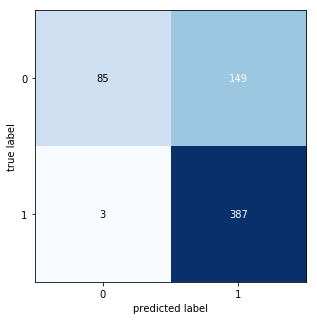

In [53]:
import matplotlib.pyplot as plt
CM = confusion_matrix(y_true, y_pred_QDA_main1)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [54]:
EXTRA_TRAIN_DIR = "C:\\Users\\Sundeep\\Desktop\\keras-oneshot-master\\rsna-pneumonia-detection-challenge\\Traindata1\\"

In [55]:
X_train_new, y_train_new = get_data(EXTRA_TRAIN_DIR)

In [56]:
X_train_new=X_train_new.reshape(3860,3,150,150)

In [57]:
BET_1 = datatoBET(X_train_new, y_train_new, model)

In [58]:
y_pred_QDA_1, y_prob_QDA_1, y_pred_gnb_1, y_prob_gnb_1 = model_pred(BET_1)

Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
accuracy for QDA classifier is: 0.6121794871794872
accuracy for Naive bayes classifier is: 0.7083333333333334


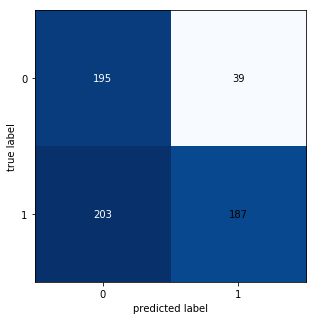

In [59]:
import matplotlib.pyplot as plt
CM = confusion_matrix(y_true, y_pred_QDA_1)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [60]:
EXTRA_TRAIN_DIR = "C:\\Users\\Sundeep\\Desktop\\keras-oneshot-master\\rsna-pneumonia-detection-challenge\\Traindata5\\"

In [61]:
X_train_new1, y_train_new1 = get_data(EXTRA_TRAIN_DIR)

In [62]:
X_train_new1 = X_train_new1.reshape(X_train_new1.shape[0],3,150,150)

In [63]:
BET_2 = datatoBET(X_train_new1, y_train_new1, model)

In [64]:
y_pred_QDA_2, y_prob_QDA_2, y_pred_gnb_2, y_prob_gnb_2 = model_pred(BET_2)

Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
accuracy for QDA classifier is: 0.5849358974358975
accuracy for Naive bayes classifier is: 0.7051282051282052


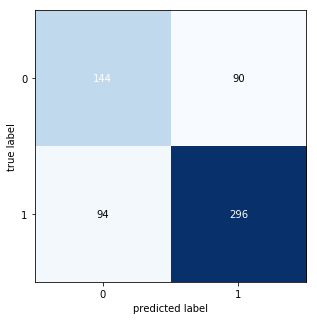

In [65]:
import matplotlib.pyplot as plt
CM = confusion_matrix(y_true, y_pred_gnb_2)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [66]:
EXTRA_TRAIN_DIR = "C:\\Users\\Sundeep\\Desktop\\keras-oneshot-master\\rsna-pneumonia-detection-challenge\\Traindata6\\"

In [67]:
X_train_new2, y_train_new2 = get_data(EXTRA_TRAIN_DIR)

In [68]:
X_train_new2 = X_train_new2.reshape(X_train_new2.shape[0],3,150,150)

In [69]:
BET_3 = datatoBET(X_train_new2, y_train_new2, model)

In [70]:
y_pred_QDA_3, y_prob_QDA_3, y_pred_gnb_3, y_prob_gnb_3 = model_pred(BET_3)

Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
accuracy for QDA classifier is: 0.6474358974358975
accuracy for Naive bayes classifier is: 0.7051282051282052


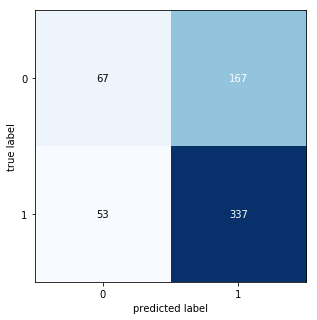

In [71]:
import matplotlib.pyplot as plt
CM = confusion_matrix(y_true, y_pred_QDA_3)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [74]:
EXTRA_TRAIN_DIR = "C:\\Users\\Sundeep\\Desktop\\keras-oneshot-master\\rsna-pneumonia-detection-challenge\\Traindata7\\"

In [75]:
X_train_new3, y_train_new3 = get_data(EXTRA_TRAIN_DIR)

In [76]:
X_train_new3 = X_train_new3.reshape(X_train_new3.shape[0],3,150,150)

In [77]:
BET_4 = datatoBET(X_train_new3, y_train_new3, model)

In [78]:
y_pred_QDA_4, y_prob_QDA_4, y_pred_gnb_4, y_prob_gnb_4 = model_pred(BET_4)

Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
accuracy for QDA classifier is: 0.657051282051282
accuracy for Naive bayes classifier is: 0.6490384615384616


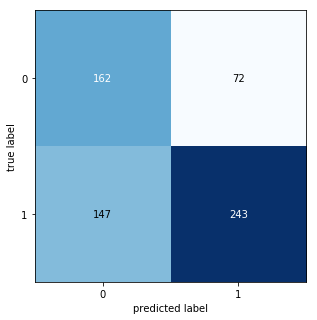

In [79]:
import matplotlib.pyplot as plt
CM = confusion_matrix(y_true, y_pred_gnb_4)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [81]:
EXTRA_TRAIN_DIR = "C:\\Users\\Sundeep\\Desktop\\keras-oneshot-master\\rsna-pneumonia-detection-challenge\\Traindata8\\"

In [82]:
X_train_new4, y_train_new4 = get_data(EXTRA_TRAIN_DIR)

In [83]:
X_train_new4 = X_train_new4.reshape(X_train_new4.shape[0],3,150,150)

In [84]:
BET_5 = datatoBET(X_train_new4, y_train_new4, model)

In [85]:
y_pred_QDA_5, y_prob_QDA_5, y_pred_gnb_5, y_prob_gnb_5 = model_pred(BET_5)

Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
accuracy for QDA classifier is: 0.3974358974358974
accuracy for Naive bayes classifier is: 0.6298076923076923


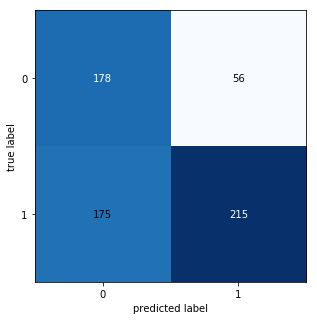

In [86]:
import matplotlib.pyplot as plt
CM = confusion_matrix(y_true, y_pred_gnb_5)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [87]:
EXTRA_TRAIN_DIR = "C:\\Users\\Sundeep\\Desktop\\keras-oneshot-master\\rsna-pneumonia-detection-challenge\\Traindata9\\"

In [88]:
X_train_new5, y_train_new5 = get_data(EXTRA_TRAIN_DIR)

In [89]:
X_train_new5 = X_train_new5.reshape(X_train_new5.shape[0],3,150,150)

In [90]:
BET_6 = datatoBET(X_train_new5, y_train_new5, model)

In [91]:
y_pred_QDA_6, y_prob_QDA_6, y_pred_gnb_6, y_prob_gnb_6 = model_pred(BET_6)

Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
accuracy for QDA classifier is: 0.4935897435897436
accuracy for Naive bayes classifier is: 0.7211538461538461


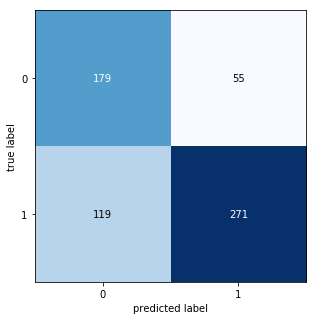

In [92]:
import matplotlib.pyplot as plt
CM = confusion_matrix(y_true, y_pred_gnb_6)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [93]:
EXTRA_TRAIN_DIR = "C:\\Users\\Sundeep\\Desktop\\keras-oneshot-master\\rsna-pneumonia-detection-challenge\\Traindata10\\"

In [94]:
X_train_new6, y_train_new6 = get_data(EXTRA_TRAIN_DIR)

In [95]:
X_train_new6 = X_train_new6.reshape(X_train_new6.shape[0],3,150,150)

In [96]:
BET_7 = datatoBET(X_train_new6, y_train_new6, model)

In [97]:
y_pred_QDA_7, y_prob_QDA_7, y_pred_gnb_7, y_prob_gnb_7 = model_pred(BET_7)

Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
accuracy for QDA classifier is: 0.6730769230769231
accuracy for Naive bayes classifier is: 0.7115384615384616


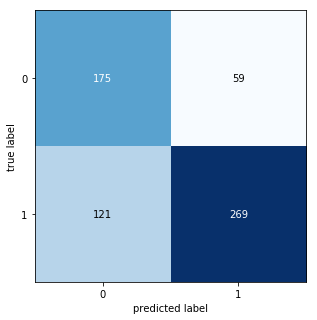

In [98]:
import matplotlib.pyplot as plt
CM = confusion_matrix(y_true, y_pred_gnb_7)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [99]:
EXTRA_TRAIN_DIR = "C:\\Users\\Sundeep\\Desktop\\keras-oneshot-master\\rsna-pneumonia-detection-challenge\\Traindata11\\"

In [100]:
X_train_new7, y_train_new7 = get_data(EXTRA_TRAIN_DIR)

In [101]:
X_train_new7 = X_train_new7.reshape(X_train_new7.shape[0],3,150,150)

In [102]:
BET_8 = datatoBET(X_train_new7, y_train_new7, model)

In [103]:
y_pred_QDA_8, y_prob_QDA_8, y_pred_gnb_8, y_prob_gnb_8 = model_pred(BET_8)

Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!
accuracy for QDA classifier is: 0.6923076923076923
accuracy for Naive bayes classifier is: 0.7532051282051282


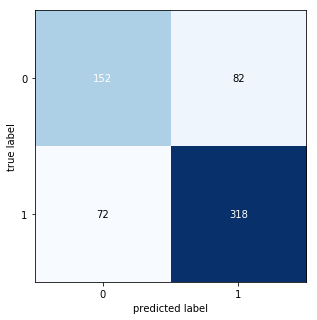

In [104]:
import matplotlib.pyplot as plt
CM = confusion_matrix(y_true, y_pred_gnb_8)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [158]:
EXTRA_TRAIN_DIR = "C:\\Users\\Sundeep\\Desktop\\keras-oneshot-master\\rsna-pneumonia-detection-challenge\\Traindata2\\"

In [159]:
X_train_new8, y_train_new8 = get_data(EXTRA_TRAIN_DIR)

In [160]:
EXTRA_TRAIN_DIR = "C:\\Users\\Sundeep\\Desktop\\keras-oneshot-master\\rsna-pneumonia-detection-challenge\\Traindata3\\"

In [161]:
X_train_new9, y_train_new9 = get_data(EXTRA_TRAIN_DIR)

In [162]:
EXTRA_TRAIN_DIR = "C:\\Users\\Sundeep\\Desktop\\keras-oneshot-master\\rsna-pneumonia-detection-challenge\\Traindata4\\"

In [163]:
X_train_new10, y_train_new10 = get_data(EXTRA_TRAIN_DIR)

In [108]:
BET_main_mod1 = datatoBET(X_train, y_train, model1)

In [109]:
intermediate_layer_model = Model(inputs=model1.input,
                                 outputs=model1.get_layer('Features_MLP').output)
intermediate_output_mod1 = intermediate_layer_model.predict(X_test)

In [111]:
# y_pred_QDA_main_mod1, y_prob_QDA_main_mod1, y_pred_gnb_main_mod1, y_prob_gnb_main_mod1 = model_pred(BET_main_mod1)

In [ ]:
import matplotlib.pyplot as plt
CM = confusion_matrix(y_true, y_pred_QDA_main_mod1)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
intermediate_layer_model = Model(inputs=model2.input,
                                 outputs=model2.get_layer('Features_MLP').output)
intermediate_output_mod2 = intermediate_layer_model.predict(X_test)

In [ ]:
# BET_main_mod2 = datatoBET(X_train, y_train, model2)
# y_pred_QDA_main_mod2, y_prob_QDA_main_mod2, y_pred_gnb_main_mod2, y_prob_gnb_main_mod2 = model_pred(BET_main_mod2)

In [ ]:
# BET_test = datatoBET(X_test, y_test, model)
y_pred_QDA_test, y_prob_QDA_test, y_pred_gnb_test, y_prob_gnb_test = model_pred(BET_test)

In [ ]:
import matplotlib.pyplot as plt
CM = confusion_matrix(y_true, y_pred_QDA_main_mod2)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

### Majority Voting

In [147]:
preds_ = pd.DataFrame(list(zip(y_pred_QDA_main1, y_pred_gnb_main1,y_pred_QDA_1, y_pred_gnb_1,y_pred_QDA_2, y_pred_gnb_2,y_pred_QDA_3, y_pred_gnb_3,y_pred_QDA_4, y_pred_gnb_4,y_pred_QDA_5, y_pred_gnb_5,y_pred_QDA_6, y_pred_gnb_6,y_pred_QDA_7, y_pred_gnb_7,y_pred_QDA_8, y_pred_gnb_8 )))
# preds_ = pd.DataFrame(list(zip(y_pred_QDA_main1, y_pred_gnb_main1,y_pred_gnb_1,y_pred_gnb_2, y_pred_gnb_3,y_pred_gnb_4,y_pred_gnb_5, y_pred_gnb_6,y_pred_gnb_7,y_pred_gnb_8, )))
preds_ = pd.DataFrame(list(zip(y_pred_QDA_main1, y_pred_gnb_main1,y_pred_QDA_1, y_pred_QDA_2,y_pred_QDA_3,y_pred_QDA_4,y_pred_QDA_5, y_pred_QDA_6, y_pred_QDA_7, y_pred_QDA_8)))
a = np.array(preds_.mode(axis=1)[0]).flatten()
sum(a == np.array(y_true)) / len(np.array(y_true))

0.7371794871794872

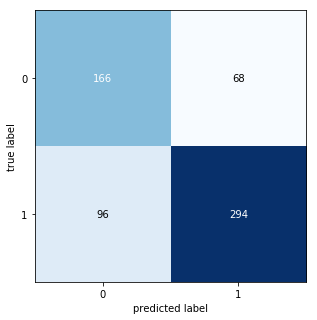

In [149]:
import matplotlib.pyplot as plt
CM = confusion_matrix(y_true, a)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

### Ensemble Predictions

In [154]:
y_pred = np.array(y_prob_QDA_main1) + np.array(y_prob_QDA_1) + np.array(y_prob_QDA_2) + np.array(y_prob_QDA_3) + np.array(y_prob_QDA_4) + np.array(y_prob_QDA_5) + np.array(y_prob_QDA_6) + np.array(y_prob_QDA_7) + np.array(y_prob_QDA_8)

q = []

for e in y_pred:
    q.append(np.argmax(e))

sum(q ==  np.array(y_true).flatten()) / len( np.array(y_true).flatten())

0.6522435897435898

In [140]:
# BET_total = BET_new5_ + BET_new4_ + BET_new3_ + BET_new2_ + BET_new1_ + BET_new_  + BET1_
BET_total =   BET_dataset1 + BET_1 + BET_2 + BET_3 + BET_4 + BET_5 + BET_6 + BET_7 + BET_8 
# BET_total  =   BET_dataset1 

In [141]:
from artml.explore import stats
df_stats = stats.univariate(BET_total)
a = np.array(df_stats.loc[['Standard_deviation']])
b = np.argwhere(a == 0)
BET_total = BET_total.drop(list(b[:,1]), 1)
BET_total = BET_total.drop(list(b[:,1]))

In [142]:
from artml.models import QDA
qda = QDA.QuadraticDiscriminantAnalysis()
qda.fit(BET_total, 'Target_0', 'Target_1')
y_pred_QDA3 = qda.predict(pd.DataFrame(intermediate_output).drop(list(b[:,1]), 1))
qda.score(pd.DataFrame(intermediate_output).drop(list(b[:,1]), 1), np.array(y_test.flatten()))

Handling zero determinent Exception with dummies!
Handling zero determinent Exception with dummies!


0.7932692307692307

In [143]:
from artml.models import naive_bayes
gnb = naive_bayes.GaussianNB()
gnb.fit(BET_total, 'Target_0', 'Target_1')
y_pred_gnb3 = gnb.predict(pd.DataFrame(intermediate_output).drop(list(b[:,1]), 1).values)
gnb.score(pd.DataFrame(intermediate_output).drop(list(b[:,1]), 1).as_matrix(), np.array(y_test.flatten()))

0.7580128205128205

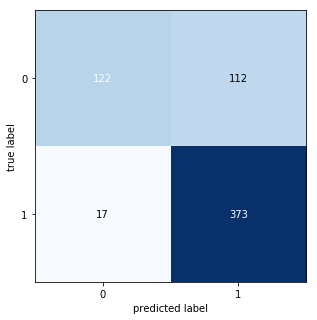

In [144]:
import matplotlib.pyplot as plt
CM = confusion_matrix(y_true, y_pred_QDA3)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [145]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, y_pred_QDA3)

(array([0.87769784, 0.76907216]),
 array([0.52136752, 0.95641026]),
 array([0.6541555 , 0.85257143]),
 array([234, 390], dtype=int64))

In [146]:
# y_pred_QDA_main1, y_prob_QDA_main1, y_pred_gnb_main1, y_prob_gnb_main1